# Conditional Density Estimator 
Using Gaussian mixture models and neural networks

- Author: Zhihan Yang
- Date: April 20, 2020
- Note: It took me so many trials and errors to adjust the hyperparameters for this notebook. I've marked all the important hyperparameters with "crucial to success" tag in comments. Don't be discouraged in math and computer science just like in life! You can do it! I wrote this note because I was a little emotional upon plotting the last plot - it looks so beautiful.

In [3]:
%reload_ext autoreload
%autoreload 2

In [4]:
import warnings

import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import mixture

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import sys
sys.path.append('../modules_for_nn_training')
from callbacks import CallbackHandler
from learner import Learner
from trainer import Trainer
from utility_callbacks import LossCallback

## Data

The wrong way to do it. But I don't really know a better way. In the right way, the x-values should be sampled instead of y-values, and the distribution of x-values should look uniform, rather than normal.

In [5]:
def get_xs_and_ys():
    ys = np.random.uniform(low=-3.2, high=1.25, size=50000)
    ys = np.array(sorted(ys))
    xs = 3 * ys ** 2 + ys ** 3
    ys += np.random.normal(scale=0.2, size=len(ys))
    return xs, ys

In [6]:
xs, ys = get_xs_and_ys()

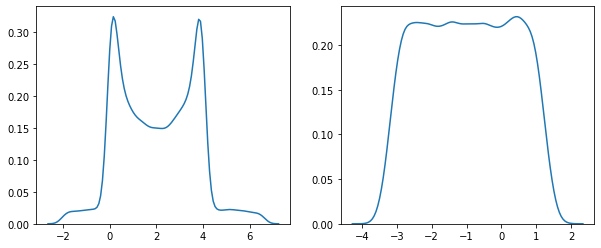

In [7]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(121)
sns.kdeplot(xs, ax=ax)
ax = fig.add_subplot(122)
sns.kdeplot(ys, ax=ax)
plt.show()

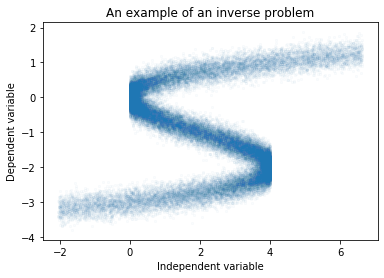

In [8]:
plt.scatter(xs, ys, s=5, alpha=0.02)
plt.title('An example of an inverse problem')
plt.xlabel('Independent variable'); plt.ylabel('Dependent variable')
plt.show()

In [9]:
xs, ys = xs.reshape(-1, 1), ys.reshape(-1, 1)

In [10]:
def train_test_split(xs, ys, train_prop):
    train_num = int(train_prop * len(xs))
    idxs = np.arange(len(xs))
    np.random.shuffle(idxs)
    train_idxs, valid_idxs = idxs[:train_num], sorted(idxs[train_num:])
    return (xs[train_idxs], ys[train_idxs]), (xs[valid_idxs], ys[valid_idxs])

In [11]:
(x_train, y_train), (x_valid, y_valid) = train_test_split(xs, ys, 0.8)

In [12]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((40000, 1), (40000, 1), (10000, 1), (10000, 1))

In [13]:
train_ds = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
valid_ds = TensorDataset(torch.from_numpy(x_valid), torch.from_numpy(y_valid))
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=64, shuffle=False)

## Model

Mixture models represent a distribution in terms of a linear combination of adaptive kernel functions.

**Mixture model for CDE.** The conditional density of target $t$ given input $x$:

$$p(\vec{t}|\vec{x})=\sum_{j=1}^M \alpha_j(\vec{x}) \phi_j(\vec{t}|\vec{x})$$

where $M$ is the number of components, $\alpha_j$'s are mixing coefficients, and $\phi_j$'s are kernel functions.

**Kernel function.** For this notebook, we restrict attention to kernel functions which are Gaussians of the form:

$$\phi_j(t|x)=\frac{1}{(2\pi)^{c/2}\sigma_j^c(\vec{x})} \exp \left\{ - \frac{\| \vec{t} - \vec{\mu}_j(\vec{x}) \| ^2}{2 \sigma_j^2(\vec{x})} \right\}$$

where:
- $c$ is the dimensionality of $\vec{t}$.
- $\sigma_j(\vec{x})$ is the common standard deviation of all dimensions of the output vectors for the $j$th kernel function given an input vector $\vec{x}$.
- $\vec{\mu}_j(\vec{x})$ is the mean of the output vectors for the $j$ kernel function given an input vector of $\vec{x}$.

The simplified Gaussian kernel function stated above can be extended to use full covariance matricess, but this is not necessary because the simplified version can approximate any given desnity function to arbitary accuracy, provided the mixing coefficients and the Gaussian parameters (mean and covariances) are correctly chosen. (McLachlan and Basford, 1988). 

$$
\phi_j(t|x)=\frac{1}{(2\pi)^{c/2} \det \left(\Sigma_j(\vec{x})\right)^{1/2}} \exp 
\left\{
-\frac{1}{2}
\left(\vec{t} - \vec{\mu}_j(\vec{x})\right) 
\Sigma^{-1} 
\left(\vec{t} - \vec{\mu}_j(\vec{x})\right)^T 
\right\}
$$

where:
- $\Sigma_j(\vec{x})$ is the covariance matrix of the $j$th kernel function given an input vector $\vec{x}$.
- $\Sigma_j(\vec{x})^{-1}$ is the inverse of the covariance matrix. 
- $\det \left(\Sigma_j(\vec{x})\right)$ is the determinant of the covariance matrix. 
- When all dimensions of the output vector $\vec{t}$ are independent and have the same variance, the covariance matrix reduces to a diagonal matrix of the form `shared_variance * np.eye(number_of_dimensions_of_t)`.
    - The determinant of the covariance matrix reduces to `shared_variance ** number_of_dimensions_of_t`.
    - The inverse of the covariance matrice reduces a `1 / shared_variance * np.eye(number_of_dimensions_of_t)`, which simply scales any vector that get multiplied with it by 1 / shared_variance.
    - These reductions help us understand how the simplified Gaussian kernel function obtained earlier was derived.

In [14]:
class CDEstimator(nn.Module):
    
    """Conditional density estimator using neural networks."""
    
    def __init__(self, input_dim, output_dim, num_comps, num_hidden):
        
        super().__init__()
        
        self.num_comps = num_comps
        self.output_dim = output_dim
        
        self.get_mixing_coeffs = nn.Sequential(
            
            nn.Linear(input_dim, num_hidden),
            nn.BatchNorm1d(num_hidden),
            nn.Sigmoid(),
            
            nn.Linear(num_hidden, num_hidden),
            nn.BatchNorm1d(num_hidden),
            nn.Sigmoid(),
            
            nn.Linear(num_hidden, num_hidden),
            nn.BatchNorm1d(num_hidden),
            nn.Sigmoid(),
            
            nn.Linear(num_hidden, num_comps),
            nn.Softmax(dim=1)
        
        )
        
        self.get_means = nn.Sequential(
        
            nn.Linear(input_dim, num_hidden),
            nn.BatchNorm1d(num_hidden),
            nn.Sigmoid(),
            
            nn.Linear(num_hidden, num_hidden),
            nn.BatchNorm1d(num_hidden),
            nn.Sigmoid(),
            
            nn.Linear(num_hidden, num_hidden),
            nn.BatchNorm1d(num_hidden),
            nn.Sigmoid(),
            
            nn.Linear(num_hidden, num_comps * output_dim),
            
        )
        
        self.get_logvars = nn.Sequential(
        
            nn.Linear(input_dim, num_hidden),
            nn.BatchNorm1d(num_hidden),
            nn.Sigmoid(),
            
            nn.Linear(num_hidden, num_hidden),
            nn.BatchNorm1d(num_hidden),
            nn.Sigmoid(),
            
            nn.Linear(num_hidden, num_hidden),
            nn.BatchNorm1d(num_hidden),
            nn.Sigmoid(),
            
            nn.Linear(num_hidden, num_comps),
        
        )
        
    def forward(self, x):
        
        mixing_coeffs = self.get_mixing_coeffs(x)
        means = self.get_means(x).view((-1, self.num_comps, self.output_dim))
        variances = torch.exp(self.get_logvars(x))
        
        return {
            'mixing_coeffs' : mixing_coeffs,
            'means' : means,
            'variances' : variances
        }

In [26]:
def get_densities_under_gmm(mixing_coeffs, means, variances, t):
    
    probas = torch.zeros(t.size(0))
    
    num_components = mixing_coeffs.size(1)
    output_dim = t.size(1)
    
    for j in range(num_components):
        probas += mixing_coeffs[:,j] * (
            1 / 
            (
                (2 * np.pi) ** (output_dim / 2) * (variances[:,j] ** 0.5) ** output_dim
            )
        ) * torch.exp(
            - torch.norm(t - means[:,j], dim=1) ** 2 / (2 * variances[:,j])
        )
    
    return probas

In [16]:
def nll_loss(params, t):
    """Negative log-likelihood loss."""
    probas = get_densities_under_gmm(params['mixing_coeffs'], params['means'], params['variances'], t)
    return - torch.sum(torch.log(probas))

In [17]:
def get_model(num_components):
    # crucial to success: the number of hidden units has to be large enough (e.g., 100 was failing)
    # crucial to success: the number of larges has to be large enough (e.g., 1 was failing)
    nn = CDEstimator(1, 1, num_components, 100)  
    return nn, optim.Adam(nn.parameters(), lr=0.01)

In [27]:
num_components = 3

model, opt = get_model(num_components)
learn = Learner(train_dl, valid_dl, model, nll_loss, opt)

loss_cb = LossCallback()
cb_handler = CallbackHandler(cbs=[loss_cb])

trainer = Trainer(learn=learn, cb_handler=cb_handler)

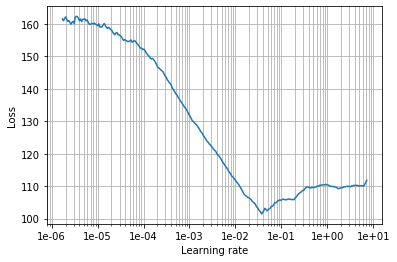

In [40]:
# crucial to success: make sure to reset this step; it gives a very poor start to training because it ends up with high loss
# or set final_value to be very small
trainer.find_lr(beta=0.98, final_value=10, num_itr=300)

In [41]:
trainer.set_lr(1e-3)
trainer.train(num_epoch=3)  # crucial to success: the more epochs the better

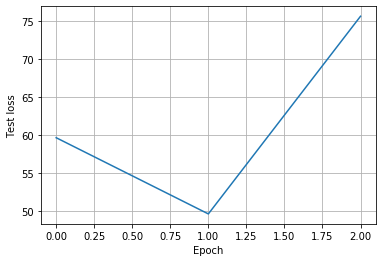

In [49]:
loss_cb.plot()
plt.show()

In [50]:
trainer.save_as_pth('cde_using_gmm_and_nn.pth')

In [28]:
trainer.load_from_pth('cde_using_gmm_and_nn.pth')

## Visualize the estimator

### Conditional mixing coefficients

In [29]:
model.cpu().eval()
model_out = model(torch.from_numpy(x_valid).float())

means = model_out['means'].detach().numpy()
variances = model_out['variances'].detach().numpy()
mixing_coeffs = model_out['mixing_coeffs'].detach().numpy()

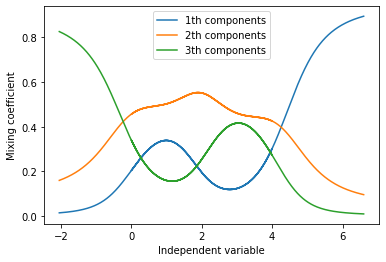

In [30]:
for i in range(num_components):
    plt.plot(x_valid.flatten(), mixing_coeffs[:,i], label=f'{i+1}th components')
plt.xlabel('Independent variable'); plt.ylabel('Mixing coefficient')
plt.legend()
plt.show()

### Conditional means and variances

**The mean of a function.** 

$$\vec{\mu} \triangleq \int_{-\infty}^{\infty} \vec{t} f(\vec{t}) d\vec{t}$$

**Conditional mean.** 

$$
\begin{align}
\langle t|x \rangle
&\triangleq\int \vec{t} p(\vec{t}|\vec{x}) d\vec{t}\\
&=\int \vec{t} \sum_{j=1}^M \alpha_j(\vec{x}) \phi_j(\vec{t}|\vec{x}) d\vec{t}\\
&=\sum_{j=1}^M \alpha_j(\vec{x}) \int \vec{t} \phi_j(\vec{t}|\vec{x}) d\vec{t}\\
&=\sum_{j=1}^M \alpha_j(\vec{x}) \vec{\mu}_j(\vec{x}) && \text{The mean of } \phi_j(\vec{t}|\vec{x}) \text{ is } \vec{\mu}_j(\vec{x}) \text{ by the definition of the mean of a function.}
\end{align}
$$

In [39]:
conditional_means = np.sum(means.reshape(len(means), 3) * mixing_coeffs, axis=1)

TODO: change the network definition to always set output dim to 1.

**The variance of a function.**

Compute the true global conditional means and variances from test data.

In [31]:
partitions = np.linspace(x_valid.min(), x_valid.max(), 50)
mid_points = []
true_cmeans = []
true_cvars = []
for i in range(len(partitions) - 1):
    start, end = partitions[i], partitions[i+1]
    mid_point = (start + end) / 2
    idxs = np.where(np.logical_and(x_train >= start, x_train < end))
    ys = y_train[idxs]
    mid_points.append(mid_point)
    true_cmeans.append(np.mean(ys))
    true_cvars.append(np.var(ys))

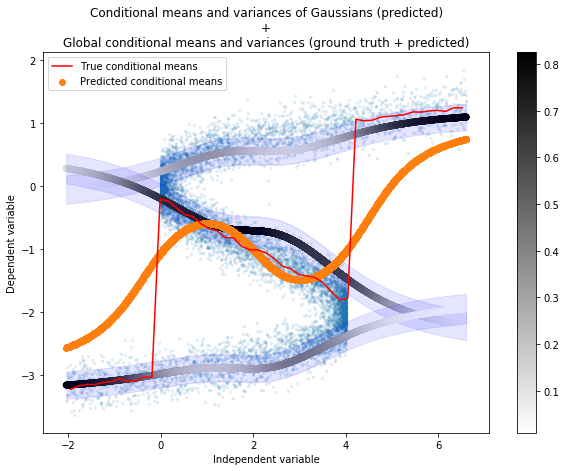

In [40]:
plt.figure(figsize=(10, 7))

plt.scatter(x_valid, y_valid, s=5, alpha=0.1)

for i in range(num_components):
    plt.scatter(
        x_valid.flatten(), 
        means[:,i],
        c=mixing_coeffs[:,i],
        cmap='binary',
    )
    plt.fill_between(
        x_valid.flatten(), 
        means[:,i].flatten() - variances[:,i] ** 0.5, 
        means[:,i].flatten() + variances[:,i] ** 0.5,
        alpha=0.1,
        color='blue'
    )
plt.colorbar()

# predicted conditional mean for each input vector in the test set
plt.scatter(x_valid.flatten(), conditional_means, label='Predicted conditional means')

# true conditional mean for each interval of input vectors in the test set
plt.plot(mid_points, true_cmeans, label='True conditional means', color='red')
    
plt.xlabel('Independent variable'); plt.ylabel('Dependent variable'); 
plt.title('Conditional means and variances of Gaussians (predicted)\n+\nGlobal conditional means and variances (ground truth + predicted)')

plt.legend()
plt.show()